In [88]:
from __future__ import print_function
from dolfin import *
import numpy as np


#dubtes i coses a revisar:
# a l'hora de normalitzar, cal normalitzar gradB? o fent f/f0 ja queda normalitzat??
# revisar tmb el grau de grad B, cal normalitzar amb br tmb??
# fer mesh no uniforme

In [109]:
# Variables:
T = 10.0      # temps total
num_steps = 100     # nombre de time steps
dt = T / num_steps            # dt
k = Constant(dt)

mu = Constant(0.000852)  # viscositat
rho = Constant(1)             # densitat

c0 = Constant(3.4*pow(10,-9)) #concentració incial
Ms = Constant(42.7)           #magnetització de saturació
dyB = Constant(95.74)         #valor absolut màxim del gradient de B (T/m)

hi = 0.015          #alçada de l'imant (m)
r = 0.007           #radi de l'imant (m)
Br = 1.45           #flux magnetic romanent (T)

#Normalització
l0 = Constant(0.01)           #longitud característica (m)
b = Constant(1)               #base de la cubeta/l0
h = Constant(3)               #altura de la cubeta/l0
f0 = c0*Ms*dyB                #força màxima?          
p0 = f0*l0                    #pressió característica
u0 = sqrt(f0*l0/rho)          #velocitat característica
t0 = l0/u0                    #temps característica
Re = rho*l0*u0/(2*mu)         #nombre de Reynolds





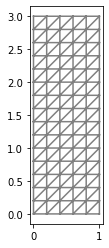

In [100]:
# Mallat uniforme
mesh=RectangleMesh(Point(0, 0), Point(b, h), 5, 15)
plot(mesh)

# Mallat no uniforme

V = VectorFunctionSpace(mesh, 'P', 2) # espai per la velocitat
Q = FunctionSpace(mesh, 'P', 1)       # espai per la pressió

In [101]:
# Definim les condicions de contorn
base  = 'near(x[1], 0) || near(x[0], 3)' 
paret   = 'near(x[0], 0) || near(x[0], 1)'


def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

#velocitat
bcu_base  = DirichletBC(V, Constant((0, 0)), base)
bcu_paret  = DirichletBC(V, Constant((0, 0)), paret)
#pressió
bcp_base  = DirichletBC(Q,  101325 , base) 
bcp_paret  = DirichletBC(Q,  101325, paret) 

bcu = [bcu_base, bcu_paret] 
bcp = [bcp_base, bcp_paret]

In [102]:
# Define trial and test functions
#velocitat
u = TrialFunction(V)
v = TestFunction(V)
#pressió
p = TrialFunction(Q)
q = TestFunction(Q)

# Define functions for solutions at previous and current time steps
u_n = Function(V)
u_  = Function(V)
p_n = Function(Q)
p_  = Function(Q)


In [103]:
# càlcul del gradB_max

y_0=0
delta_B=((Br*r**2)/2)*((pow((y_0+hi)**2+r**2,-3/2))-(pow(y_0**2+r**2,-3/2)))
print(delta_B)

-95.73878719713858


In [104]:
# Define expressions used in variational forms
gradB = Expression(('((1.45*0.007*0.007)/2)*((pow((x[1]+1.5)*(x[1]+1.5)+0.007*0.007,-3/2))-(pow(x[1]*x[1]+0.007*0.007,-3/2)))/95.74'), degree=2)
M   = Constant([0,1])
c   = Constant(1)
U   = 0.5*(u_n + u)
n   = FacetNormal(mesh)
f   = c*M*gradB

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return epsilon(u)/Re - p*Identity(len(u))

In [105]:
# Define variational problem for step 1
F1 = dot((u - u_n) / k, v)*dx + \
     dot(dot(u_n, nabla_grad(u_n)), v)*dx \
   + inner(sigma(U, p_n), epsilon(v))*dx \
   + dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds \
   - dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

# Define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/k)*div(u_)*q*dx

# Define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - k*dot(nabla_grad(p_ - p_n), v)*dx



In [106]:
# Assemble matrices
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

# Apply boundary conditions to matrices
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

Calling FFC just-in-time (JIT) compiler, this may take some time.


[None, None]

In [110]:
import matplotlib.pyplot as plt

# Time-stepping
t = 0
for n in range(num_steps):

    # Update current time
    t += dt

    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)

    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)

    # Step 3: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)

    

    # Update previous solution
    u_n.assign(u_)
    p_n.assign(p_)






Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


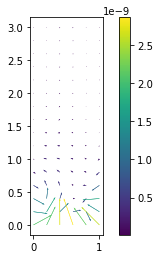

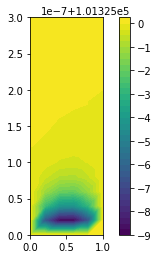

In [111]:
# Plot solution    
plot(u_)

c=plot(u_)
plt.colorbar(c)
plt.show()

c_=plot(p_)
plt.colorbar(c_)
plt.show()